# Tutorial for Community Detection using Hybrid Quantum Annealing on Amazon Braket

Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: MIT-0

This tutorial is related to the blog post on ['Community Detection in Complex Networks using Hybrid Quantum Annealing on Amazon Braket'](https://aws.amazon.com/blogs/quantum-computing/community-detection-in-complex-networks-using-hybrid-quantum-annealing-on-amazon-braket-part-i/).

[Community structure detection](https://en.wikipedia.org/wiki/Community_structure) is an important problem in network analysis. Applications can be found for example in biology for atomistic representation of complex proteins, in social media for the network analysis of human communication, and in business operations for customer segmentation and fraud detection. Overall, the goal of community detection is to detect the appearance of densely connected groups of nodes in a graph, with only sparser connections between groups.

In this tutorial, we provide a step-by-step guide on how to formulate community detection as a Quadratic Unconstrained Binary Optimization ([QUBO](https://en.wikipedia.org/wiki/Qubo)) problem. We then demonstrate how to use the open source [QBSolv library](https://github.com/dwavesystems/qbsolv) which offers a D-Wave hybrid solver to solve community detection problems on Amazon Braket.

## Table of contents
* [Modularity-based Community Detection](#Modularity)
* [Community Detection as a QUBO Problem](#QUBO_matrix)
    * [Two communities (k=2)](#two_communities)
    * [Multiple communities](#multi_communities)
        * [One-Hot Encoding](#one_hot_encoding)
        * [Generalized QUBO formulation](#qubo_formulation)
* [Datasets](#datasets)
* [List of Key Functions for Community Detection](#list_functions)
* [Set Up Environment](#Set_Up_Environment)
    * [Helper Functions for Community Detection](#functions)
* [Download Graph Data](#download_graph)
* [Prepare Graph for Community Detection](#create_graph)
    * [Built-In Graph](#Built-in_Graph)
    * [Graph from a Local Data File](#local_graph)
    * [Random Partition Graph](#random_graph)
* [Apply QBSolv for Community Detection](#QBSolv_run)
    * [Set Community Parameters for a Graph](#param_graph)
    * [Set Hyperparameters for QBSolv](#hyperparam_QBSolv)
    * [Execute QBSolv Classical Solver](#run_qbsolv_classical)
    * [Execute QBSolv Hybrid Solver](#run_qbsolv_hybrid)
* [Detect Communities for Synthetic and Real-World Graphs](#Supplementary)
    * [Study a Set of Synthetic Graphs](#random_graph_study)
    * [Study a Set of Real-World Graphs](#real_graph_study)

## Modularity-based Community Detection <a name="Modularity"></a>

The general notion of community structure in complex networks was first proposed and analyzed by Girvan and Newman [[1](https://www.pnas.org/content/99/12/7821)]. The basic idea is to divide a network (or graph) into sets of nodes belonging to different communities (also called clusters), where nodes within any of these communities are highly connected (high intra-connectivity), while nodes in different communities are less connected (low inter-connectivity).

To quantify the quality of a network division into communities, Newman and Girvan introduced a metric called modularity $M$. The modularity compares the connectivity of edges within communities with the connectivity of a network (the *null model*) where edges would be randomly placed, but under the constraint that expected degree of each node matches the degree of the node in the original graph [[2](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.69.026113)].

Formally, we consider a graph $G$ with corresponding adjacency matrix $A_{ij}$ describing the weight between nodes $i$ and $j$. For the null model, the expected number of edges between nodes $i$ and $j$ is (approximately) given by $g_{i}g_{j}/2m$ [[3](https://en.wikipedia.org/wiki/Modularity_(networks))], where $g_{i}=\sum_{j}A_{ij}$ is the degree of node $i$ and $m=1/2 \sum_{i} g_{i}$ is the total number of weights in the graph. Taking the random graph as null model, one can then define the modularity $M$ as $A_{ij} - g_{i}g_{j}/2m$, summed over all pairs of vertices $i,j$ that fall within in the same group.

Introducing a conventional pre-factor for normalization, we then arrive at the modularity metric $M$ defined as

\begin{equation*}
M = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{g_ig_j}{2m}\right)\delta(c_i,c_j),
\tag{1}
\label{eq:modularity-general}
\end{equation*}

where the Kronecker delta $\delta(c_i, c_j)$ is $1$ if node $i$ and node $j$ are in the same community, and $0$ otherwise.

The search for the optimal (largest) modularity value is known to be an NP-hard problem [[4](https://arxiv.org/abs/1608.00163)], with the space of possible partitions growing exponentially with the system size. The goal is then to maximize the modularity $M$ by assigning optimal community assignments $c_i$ to every node in the graph.

**The code implementation for the modularity matrix** can be found in `./src/qubo_community/modularity_mx`.

## Community Detection as a QUBO Problem <a name="QUBO_matrix"></a>

Many heuristic search algorithms have been developed for the community detection problem [[4](https://arxiv.org/abs/1608.00163)]. In this tutorial, we focus on formulating the community detection problem as a Quadratic Unconstrained Binary Optimization (QUBO) problem as outlined in Ref. [[5](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227538)], and demonstrate how to use D-Wave's `QBSolv` solver on Amazon Braket to detect two or more communities in a given network.

### Two communities ($k=2$) <a name="two_communities"></a>

Let us first consider the case where we look for a graph partitioning into $k=2$ communities. In this case, we can use binary spin variables $s_{i}\in\{-1, 1\}$ (or bit variables $x_{i}\in\{0, 1\}$) to encode which community node $i$ belongs to. 
Using the fact that the quantity $(1+s_{i}s_{j})/2$ equals $1$ if nodes $i$ and $j$ belong to the same community, and $0$ otherwise, the modularity matrix can be expressed in compact form as [[5](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227538)]:

\begin{equation*}
M = \frac{1}{4m}\vec{s}^T B \vec{s},
\tag{2}
\label{eq:modularity-max}
\end{equation*}

where the modularity matrix $B$ has been introduced as 

\begin{equation*}
B_{ij} = \left( A_{ij} - \frac{g_i g_j}{2m}\right).
\tag{3}
\label{eq:modularity-matrix}
\end{equation*}

Using the conversion $s_i=2x_i-1$, and the fact that $\sum_{i,j}B_{ij}=0$, the maximization of the modularity [Eq. (3)] can be expressed equivalently as a minimization problem of QUBO form, with QUBO Hamiltonian $H=-\left(1/m\right){\vec{x}}^TB\vec{x}$, and with QUBO matrix $Q= -B/m$. QUBO matrices like this one can be readily passed to a quantum annealing device such as D-Wave, which will then try to find the optimal bitstring $\vec{x}$ that encodes the solution to our optimization problem.

### Multiple communities ($k>2$) <a name="multi_communities"></a>

Let us now turn to the more general problem of community detection with $k>2$ communities. In this case, we have to resort to Eq. (1), but we note that the function $\delta\left(c_i,c_j\right)$ is not necessarily a quadratic binary variable function. In order to formulate the $k$-community detection problem in canonical QUBO form (as required for quantum-native and quantum-inspired annealing), we take the following steps to construct the corresponding QUBO matrix.


#### One-Hot Encoding <a name="one_hot_encoding"></a>

We use a one-hot-encoding scheme where we set the decision variable $x_{i,c}=1$ if node $i$ belongs to community $c$, and $x_{i,c}=0$ otherwise, i.e., 

\begin{equation*}
x_{i,c} = 
\begin{cases}
1 & \mbox{if node } i \mbox{ is in community } c \\
0 & \mbox{otherwise}
\end{cases}
\tag{4}
\label{eq:one-hot-encoding}
\end{equation*}

With this encoding we need $k$ variables per logical node, and the size of the binary decision vector $\vec{x}$ increases from a vector of length $N$ for the two-community case to $k\times N$ for the $k$-community case. Specifically, we set $\vec{x}=\left(x_{1,1},x_{2,1},\ldots,x_{N,1},\ldots,x_{1,k},x_{2,k},\ldots,x_{N,k}\right)$.

#### Generalized QUBO formulation <a name="qubo_formulation"></a>

Accordingly, we can generalize the $k=2$ QUBO problem with Hamiltonian $H=\vec{x}^T Q \vec{x}$ to the $k>2$ setting as expressed by a minimization problem for the $k$-community QUBO Hamiltonian $H=-(1/m)\sum_{c=1}^{k}\vec{x_{c}}^T B \vec{x_{c}}$, with every term in the sum describing the community detection problem for a community $c$.

Introducing the generalized modularity matrix $\mathcal{B}$ of size $kN \times kN$ and block-diagonal form with $B$ along the diagonal as

\begin{equation*}
  \mathcal{B} = \frac{1}{m}
  \begin{bmatrix}
    B & & \\
    & \ddots & \\
    & & B
  \end{bmatrix}  
\tag{5}
\label{eq:modularity-matrix-block}
\end{equation*}

we can re-write the $k$-community detection problem as a minimization problem captured by the QUBO Hamiltonian

\begin{equation*}
H = -\vec{x}^T \mathcal{B} \vec{x}.
\tag{6}
\label{eq:qubo-general}
\end{equation*}

_Constraints_: Since each node $i=1, \dots, N$ must be in exactly one community $c=1, \dots, k$, we need to add a constraint term. 
This type of constraint is well-known from the canonical graph coloring problem where each node must be colored with exactly one color. 
Formally, it can be written as 

\begin{equation*}
\sum_{j=1}^{k}{x_{i,c}} = 1, 
\tag{7}
\label{eq:constraint}
\end{equation*}

for $i=1, \dots,N$. This linear constraint can be added to the QUBO problem with a quadratic penalty term, as described by the penalty Hamiltonian

\begin{equation*}
H_{P} = \sum_{i=1}^{N} P_{i} \left(\sum_{c=1}^{k} x_{i,c} - 1 \right)^2, 
\tag{8}
\label{eq:penalty}
\end{equation*}

with positive prefactors $P_{i}>0$ enforcing the constraints, driving the minimization therefore to valid solutions that satisfy the constraints Eq. (7). 

To construct a $Q$ matrix for the Eq.(8) penalty term $H_{P} = \vec{x}^T Q \vec{x}$, we first re-number the binary decision vector using a single subscript, from 1 to $kN$, as follows:

\begin{equation*}
\vec{x} = (x_{1,1}, x_{2,1}, \dots , x_{N,1}, \dots , x_{N, k}) = (x_{1}, x_{2}, \dots, x_{N}, \dots, x_{kN})
\tag{9}
\label{eq:re_number}
\end{equation*}

By setting $p_{i}$ as a constant $\alpha$, the penalty term Eq. (8) can be rewritten as:

\begin{equation*}
H_P=\alpha\left(V\vec{x}-\vec{b}\right)^T\left(V\vec{x}-\vec{b}\right)
\tag{10}
\label{eq:new_penalty}
\end{equation*}

where b is a vector of all ones and $V$ is a $N \times kN$ matrix:

\begin{equation*}
V=\left[\begin{matrix}I_N&\cdots&I_N\end{matrix}\right]
\tag{11}
\label{eq:V_matrix}
\end{equation*}

where $I_{N}$ is a $N \times N$ identity matrix, and $Vx-b = 0$ if all constraints are satisfied.

We expand Eq. (10) and drop the constant term ${\vec{b}}^T\vec{b}$. Using $x_i=x_i^2$, the penalty term can be rewritten as a QUBO Hamiltonian:

\begin{equation*}
Q_P = \alpha \left(V^TV-2I\right)
\tag{12}
\label{eq:Q_P}
\end{equation*}

where $I$ is a $kN \times kN$ identity matrix.


Combining the modularity QUBO matrix in Eq. (5) and the penalty QUBO matrix in Eq. (12), we have the final QUBO Hamiltonian for $k$-community detection:

\begin{equation*}
\mathrm{H\ =}{\vec{x}}^T\left(-\mathcal{B}+\alpha\left(V^TV-2I\right)\right)\vec{x}
\tag{13}
\label{eq:qubo_k}
\end{equation*}

with the penalty coefficient $\alpha$ enforcing the constraint terms $\sum_{c=1}^{k}x_{i,c}=1$. The QUBO matrix in Eq. (13) has a size of $kN \times kN$ which scales with both the number of nodes $N$ in the network and the number of communities $k$, due to the overhead of embedding a $k$-class variable in a binary variable.

**The code implementation for the QUBO matrix** can be found in `./src/qubo_community/qubo_matrix_community_sparse`.

## Datasets <a name="datasets"></a>
The graph datasets used for demonstration here are downloaded from http://networkrepository.com/ under a Creative Commons Attribution-ShareAlike License. Dataset reference: Rossi, Ryan A.  and Ahmed, Nesreen K. (2015) The Network Data Repository with Interactive Graph Analytics and Visualization. AAAI https://networkrepository.com.

For illustration, below we display an example for $k=4$ communities with a modularity value of $\sim 0.42$, as found with D-Wave's `QBSolv` solver for the well-known [Zachary karate club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club): (figure from author)

<img src="image/Karate_DwaveQBSolv_4comm_modu0.4198.png" width="500"/>

## List of Key Functions <a name="list_functions"></a>

* Script '*src/graph_community.py*': graph data preparation 
    1. class `CommunityGraphFactory()`: load a local graph file or create a random partition graph
    2. function `load_node_labels()`: load the community (or group) labels for nodes in a random partition graph
    
    
* Script '*src/qbsolv_community.py*': QBSolv solver execution
    1. class `QbsolvCommunity()`: solve QUBO optimization problem using either the QBSolv classical solver or hybrid solver
    2. class `CommunityDetectionSolver()`:  built on top of `qbsolv_community()` with added features to track and save detailed results
    
    
* Script '*src/qubo_community.py*': modularity matrix and QUBO matrix construction
    1. function `modularity_mx()`: create a modularity matrix for a NetworkX graph
    2. function `qubo_matrix_community_sparse()`: create a QUBO matrix for a community detection task
    3. function `qbsolv_response_to_community()`: convert QBSolv results to communty structure results of a graph

## Set Up Environment <a name="Set_Up_Environment"></a>

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pandas as pd
import collections
from collections import defaultdict
from itertools import combinations
import itertools
import math
import networkx as nx
import numpy as np
import json
import os
import datetime
from networkx.algorithms import community
import scipy.sparse as sp
import warnings
import pickle

### Helper Functions for Community Detection <a name="functions"></a>

In [22]:
import sys
sys.path.insert(1, './src')
from utils import download_graphs, clean_graph_data
from graph_community import CommunityGraphFactory, load_node_labels, draw_graph_community
from qbsolv_community import QbsolvCommunity, CommunityDetectionSolver

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [11]:
# Create a output folder to store files
if not os.path.exists('output'):
    os.makedirs('output')
    
# get timenow for file naming 
timenow = str(datetime.datetime.now())[:19]

## Download Graph Data <a name="download_graph"></a>

In this tutorial, we demonstrate community detection using both real-world graphs and synthetic graphs. We provide code examples below to download real-world graphs from http://networkrepository.com and cleanse the data files. 

In [12]:
# set a directory to store graph data
data_dir = "./data"

# find graph zip file url from http://networkrepository.com/ 
graph_url = {'jazz': 'http://nrvis.com/download/data/misc/arenas-jazz.zip',
           'dolphins': 'http://nrvis.com/download/data/misc/dolphins.zip',
           'LesMiserables': 'http://nrvis.com/download/data/misc/lesmis.zip',
           'elegans': 'http://nrvis.com/download/data/misc/celegans_metabolic.zip',
           'emailuniv': 'https://nrvis.com/download/data/ia/ia-email-univ.zip',
           'cora': 'https://nrvis.com/download/data/labeled/cora.zip'}

In [13]:
# download graph zip file from http://networkrepository.com/ and store the data under data_dir
download_graphs(graph_url, data_dir)

Created ./graph_data directory in local machine to store graph data.


To cleanse raw data files, we need to manually examine the downloaded graph files: 

 1. Identify the name of a graph file that contains node-to-node connection and the edge weight data.
 2. Open that graph file and count how many header lines are there. We will need to skip the header lines when load the graph data for community detection.
 3. Create the `graph_files` dictionary as shown below for graph data cleanse by removing header lines.

In [14]:
graph_files = {'Jazz': {'file': 'arenas-jazz.edges', 'lines_to_skip': 1},
               'Dolphins': {'file': 'dolphins.mtx', 'lines_to_skip': 2},
               'LesMiserables': {'file': 'lesmis.mtx', 'lines_to_skip': 2},
               'Elegans': {'file': 'celegans_metabolic.mtx','lines_to_skip': 2},
               'Emailuniv': {'file': 'ia-email-univ.mtx', 'lines_to_skip': 2},
               'Cora': {'file': 'cora.edges', 'lines_to_skip': 0}
              }

In [15]:
# cleanse graph data files: remove header lines and save the graph file to a graph specific directory
clean_graph_data(graph_files, data_dir)

## Prepare a Graph for Community Detection <a name="create_graph"></a>

We prepare graph data as an input for community detection via three ways: 1) use NetworkX built-in graphs; 2) load a graph from a local file; 3) create a synthetic graph via NetworkX's random partition graph.

In [16]:
# call CommunityGraphFactory for graph data preparation
cgf = CommunityGraphFactory(seed=1)

In order to load a graph from local data files via a name, we create a dictionary `graph_file_dict` with graph names, their local file path, and the delimiter used in the file. 

`graph_file_dict` is required to have this format: {graph_name: [data_path, delimiter]}

In [17]:
graph_file_dict = {"Jazz": ["./data/Jazz/arenas-jazz.edges", ","], 
                   "Dolphins": ["./data/Dolphins/dolphins.mtx", None],
                   "LesMiserables": ["./data/LesMiserables/lesmis.mtx",None],
                   "Elegans": ["./data/Elegans/celegans_metabolic.mtx", None],
                   "Emailuniv": ["./data/Emailuniv/ia-email-univ.mtx", None],
                   "Cora": ["./data/Cora/cora.edges", ","]}

### Built-In Graph <a name="Built-in_Graph"></a>

This code example shows how to create the Zachary's karate club graph using NetworkX's built-in graph function, and draws the graph.

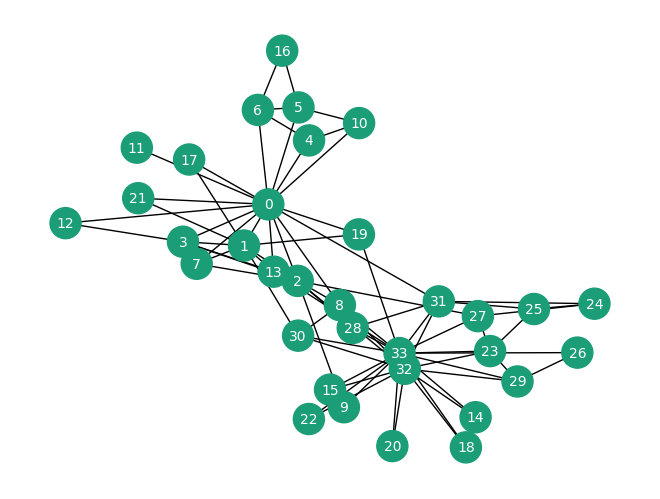

In [18]:
# using networkx graph
graph_name = "Zachary"
graph_zachary = nx.karate_club_graph()
draw_graph_community(graph_zachary, [list(range(graph_zachary.number_of_nodes()))], color_map = 'Dark2')
plt.show()

### Graph from a Local Data File <a name="local_graph"></a>
This code example shows how to create a graph through loading a local data file listed in `graph_file_dict`.

In [23]:
# load a graph from local files defined in 'graph_file_dict'
graph_name = "Dolphins"
graph_dolphins = cgf.load_graph(graph_name, graph_file_dict)
draw_graph_community(graph_dolphins, [list(range(graph_dolphins.number_of_nodes()))], color_map = 'Dark2')
plt.show()

AttributeError: module 'networkx' has no attribute 'info'

### Random Partition Graph <a name="random_graph"></a>

This code example shows how to create a synthetic graph using NetworkX's random partition graph. The [NetworkX random partition graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.random_partition_graph.html) has pre-defined community structure; therefore we can evaluate the community assignments found by QBSolve against this ground-truth label data.

iterating graph generation with random seed 2
iterating graph generation with random seed 3
iterating graph generation with random seed 4
Name: stochastic_block_model
Type: Graph
Number of nodes: 60
Number of edges: 157
Average degree:   5.2333


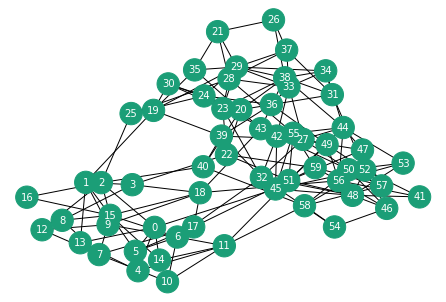

In [12]:
# create a random partition graph
graph_name = "random"
total_nodes = 60 # the number of nodes in a graph
num_comm = 3 # the number of communities
prob_in = 0.2 # probability of intra-community edge connection
prob_out = 0.02 # probability of inter-community edge connection

graph_random = cgf.create_random_graph(total_nodes, num_comm, prob_in, prob_out)

draw_graph_community(graph_random, [list(range(graph_random.number_of_nodes()))], color_map = 'Dark2')
plt.show()

The code example below demonstrates how to calculate the modularity value using the pre-defined community labels for a random partition graph. This modularity value can be used as a target baseline value to evaluate against with the QBSolv solution for community detection. The code example also shows how to draw a network with nodes colored by their community labels.

The modularity value for the pre-defined labels is 0.4843


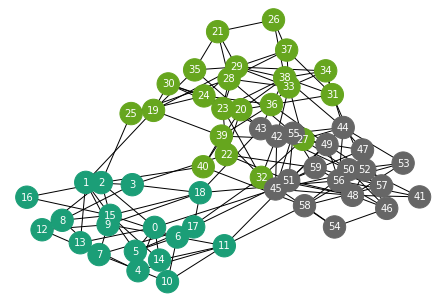

In [13]:
# load nodes' community labels and calculate its modularity value
file_path = f"./data/synthetic/node_labels_{total_nodes}_{num_comm}_{prob_in}_{prob_out}.node_labels"
label_nodes_dict, label_community, labels_array = load_node_labels(file_path)
modu_labels= community.modularity(graph_random, label_community)
print(f"The modularity value for the pre-defined labels is {round(modu_labels,4)}")

# plot a random partition graph with their nodes colored by label groups
draw_graph_community(graph_random, label_community, color_map = 'Dark2')
savefig_name = f"{timenow}_{graph_name}_labels_{num_comm}_comm_modu_{round(modu_labels, 4)}.png"
plt.savefig(os.path.join("./output", savefig_name), dpi=150)
plt.show()

## QBSolv for Community Detection <a name="QBSolv_run"></a>

`QBSolv` is a hybrid solver that decomposes large QUBO problems into smaller QUBO sub-problems. The sub-problems are then solved individually, using either QBSolv on the D-Wave QPUs (hereafter referred to as hybrid solver), or QBSolv with the classical Tabu solver alone (hereafter referred to as classical solver). The solution to the original QUBO problem is then constructed by stitching together the results of the smaller sub-problems. More technical details can be found in the [D-Wave QBSolv whitepaper](https://docs.ocean.dwavesys.com/projects/qbsolv/en/latest/_downloads/bd15a2d8f32e587e9e5997ce9d5512cc/qbsolv_techReport.pdf) and the [D-Wave QBSolv documentation](https://docs.ocean.dwavesys.com/projects/qbsolv/en/latest/).

The code examples below demonstrate how to solve community detection problems using QBSolv.

### Set Community Parameters for a Graph <a name="param_graph"></a>

We choose a graph and set the number of communities to detect.

In [14]:
# Graph parameters
## Option 1: use a NetworkX built-in graph that was created in the previous section
k = 4
graph_name = "Zachary"
nx_G = graph_zachary

## Option 2: use a real-world graph that was created in the previous section
# k = 5
# graph_name = 'Dolphins'
# nx_G = graph_dolphins

## Option 3: use a synthetic graph that was created in the previous section
# k = 3
# graph_name = "random"
# nx_G = graph_random

### Set Hyperparameters for QBSolv <a name="hyperparam_QBSolv"></a>
We configure the QBSolv settings. Remember to set the S3 bucket name to your S3 bucket with a name beginning with "amazon-braket-"; you may have created such a bucket when you were onboarded to Amazon Braket.

In [15]:
# QBSolv parameters
solver_limit = 40 # the maximum number of variables (n) for sub-QUBOs
num_repeats = 1 # the maximum iterations to repeat QBSolv solver execution to discover a new best solution
num_reads = 1000 # how many times the annealing is performed
seed = 1 # random seed
alpha = 5 # the penalty coefficient to enforce assigning only one community to each node

# for QBSolv hybrid only
device_arn = 'arn:aws:braket:::device/qpu/d-wave/Advantage_system4' # D-Wave QPU Device ARN
my_prefix = f"{graph_name}_k{k}_sl{solver_limit}_nr{num_repeats}_s{num_reads}_seed{seed}" #the folder name in the S3 braket bucket
my_bucket = f"amazon-braket-your-bucket-name-here" # rename 'amazon-braket-your-bucket-name-here' with the name of your amazon S3 Braket bucket
s3_folder = (my_bucket, my_prefix)

print(f"S3 path for saving QBSolv results: {my_bucket}/{my_prefix}")

S3 path for saving QBSolv results: amazon-braket-8c8bf2e4cf2e/Zachary_k4_sl40_nr1_s1000_seed1


### Initialize QbsolvCommunity Class <a name="init_qbsolv"></a>

In [16]:
qbsolv_comm = QbsolvCommunity(nx_G, solver_limit, num_repeats, num_reads, seed, alpha)

### Execute QBSolv Classical Solver <a name="run_qbsolv_classical"></a>

The code example below shows how to solve community detection using the QBSolv **classical solver**.
The QBSolv solver response presents solution values for the decision vector Eq. (9) in columns indexed by 0, 1, ..., kN-1. For the Zachary’s karate club graph there are $N=34$ nodes and we want to detect $k=4$ communities, so the solver response has $kN = 136$ columns.

Each row in the response represents one possible solution for the decision vector Eq. (9). Not all solutions are optimal, and the number of returned solutions depends on the graph and QBSolv hyperparameter settings. We only choose a solution with the lowest energy as the answer for community assignment.

For the Zachary’s karate club, the highest modularity reported in literature is 0.41979, seen in Ref. [5](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227538). The QBSolv classical solver can achieve this modularity with the right QBSolv settings. 

In [17]:
comm_classical, _ = qbsolv_comm.solve_classical(k)
print(f"The best solution's modularity value is: {comm_classical['modularity']}")

The size of the QUBO matrix in dictionary format for 4-community is 5032
Mode: Classical, time spent is 0.36 seconds for 1 repetitions
    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 135    energy num_oc.
0   1  1  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0 ...   0  -5.41979       1
1   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0  -5.41979       1
2   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0  -5.41979       1
3   0  0  0  0  0  0  0  0  1  1  0  0  0  0  1  1  0 ...   0  -5.41979       1
4   1  1  1  1  0  0  0  1  0  1  0  1  1  1  0  0  0 ...   0 -5.418803       1
5   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -5.418803       1
6   0  0  0  0  1  1  1  0  0  0  1  0  0  0  0  0  1 ...   0 -5.418803       1
7   0  0  0  0  1  1  1  0  0  0  1  0  0  0  0  0  1 ...   0 -5.418803       1
8   1  1  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0 ...   0 -5.417406       1
9   0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0 ...   0 -5.

`qbsolv_comm` calls a function 'qbsolv_response_to_community' to extract communities from QBSolv responses and calculate its modularity. Here we print out the extracted community result, and visualize the graph partition.

In [18]:
print(comm_classical)

{'modularity': 0.4197896120973035, 'num_comm': 4, 'comm': [{0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21}, {4, 5, 6, 10, 16}, {32, 33, 8, 9, 14, 15, 18, 20, 22, 26, 29, 30}, {23, 24, 25, 27, 28, 31}]}


In [19]:
# We save the QBSolv response to a local pickle file
response_file = f"{timenow}_DwaveQBSolv_Classical_response_{my_prefix}.p"
pickle.dump(comm_classical, open('./output/'+response_file, "wb" ))

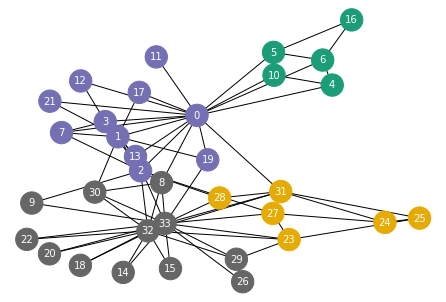

Saved figure to ./output: 2021-11-08 17:58:15_Zachary_DwaveQBSolv_classical_K4_Modu_0.4198.png


In [20]:
# We plot a graph colored with communities and save it as an image
draw_graph_community(nx_G, comm_classical['comm'], color_map = 'Dark2')
savefig_name = f"{timenow}_{graph_name}_DwaveQBSolv_classical_K{k}_Modu_{round(comm_classical['modularity'], 4)}.png"
plt.savefig(os.path.join("./output", savefig_name), dpi=150)
plt.show()
print(f"Saved figure to ./output: {savefig_name}")

### Execute QBSolv Hybrid Solver <a name="run_qbsolv_hybrid"></a>

Now we demonstrate how to use the QBSolv **hybrid solver** to solve community detection problems.

Similar to the classical solver, the QBSolv solver response presents solution values for the decision vector Eq. (9) in columns indexed by 0, 1, ..., kN-1. For the Zachary’s karate club graph there are $N=34$ nodes and we want to detect $k=4$ communities, so the solver response has $kN = 136$ columns.

Each row in the response represents one possible solution for the decision vector Eq. (9). Not all solutions are optimal, and the number of returned solutions depends on the graph and QBSolv hyperparameter settings. We only choose a solution with the lowest energy as the answer for community assignment.

For the Zachary’s karate club, the highest modularity reported in literature is 0.41979, seen in Ref. [5](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227538). The QBSolv hybrid solver can achieve this modularity with the right QBSolv settings. 

In [21]:
comm_hybrid, _ = qbsolv_comm.solve_hybrid(k, s3_folder, device_arn)
print(f"Modularity value is: {comm_hybrid['modularity']}")

The size of the QUBO matrix in dictionary format for 4-community is 5032


Continue to execute QBSolv Hybrid job: Y or N? Y


Mode: Hybrid, time spent is 49.79 seconds for 1 repeats
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 135    energy num_oc.
0  1  1  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0 ...   1  -5.41979       1
1  1  1  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0 ...   1  -5.41979       1
2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -5.395874       1
3  1  1  1  1  0  0  0  1  0  1  0  1  1  1  0  0  0 ...   0 -5.395874       1
4  1  1  1  1  0  0  0  1  0  0  0  0  0  1  0  0  0 ...   1 -5.391437       1
['BINARY', 5 rows, 5 samples, 136 variables]
Modularity value is: 0.4197896120973035


As in the previous case, we print out the extracted community, save the response to a local file, and visualize the graph partition.

In [22]:
print(comm_hybrid)

{'modularity': 0.4197896120973035, 'num_comm': 4, 'comm': [{0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21}, {4, 5, 6, 10, 16}, {32, 33, 8, 9, 14, 15, 18, 20, 22, 26, 29, 30}, {23, 24, 25, 27, 28, 31}]}


In [23]:
# We save the QBSolv response to a local pickle file
response_file = f"{timenow}_DwaveQBSolv_Hyrid_response_{my_prefix}.p"
pickle.dump(comm_hybrid, open('./output/'+response_file, "wb" ))

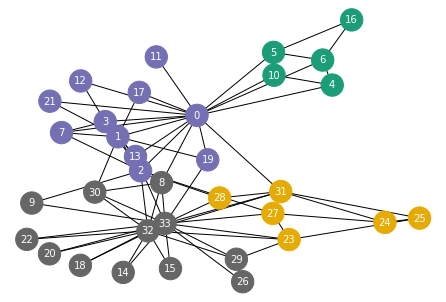

Saved figure to ./output: 2021-11-08 17:58:15_Zachary_DwaveQBSolv_hybrid_4_comm_modu_0.4198.png


In [24]:
# We plot a graph colored with communities and save it as an image
draw_graph_community(nx_G, comm_hybrid['comm'], color_map = 'Dark2')
savefig_name = f"{timenow}_{graph_name}_DwaveQBSolv_hybrid_{k}_comm_modu_{round(comm_hybrid['modularity'], 4)}.png"
plt.savefig(os.path.join("./output", savefig_name), dpi=150)
plt.show()
print(f"Saved figure to ./output: {savefig_name}")

## Community Detection for Synthetic Graphs and Real-World Graphs <a name="Supplementary"></a>
The reason we want to study both synthetic graphs and real-world graphs is to get a holistic view of how good the QBSolv community detection method is:
   1. The community results of real-world graphs can be evaluated against some of the published results, for example in Ref. [[5](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227538)].
   2. Synthetic graphs have ground-truth community labels; therefore we can assess the QBSolv solution quality by comparing to the labeled data. In addition, we can study the impact of a specific graph property on QBSolv solution quality, by varying the graph size, number of communities, probability of edges within communities, and probability of edges between communities. 
   
The code examples below demonstrate community detection using synthetic graphs with different graph configurations and using real-world graphs. 

### Study a Set of Synthetic Graphs <a name="random_graph_study"></a>

Because synthetic graphs have ground-truth labels for node communities, we can calculate the corresponding modularity value and use it as a target baseline value to evaluate against with the community solution found by QBSolv. By studying the difference between QBSolv solution and grounth truth labels for a various types of synthetic graphs, we can systematically assess the QBSolv solution performance in terms of accuracy, generalizability, and scalability.

The code examples below demonstrate community detection for synthetic graphs by varying graph properties in terms of graph size (num of nodes), number of communities (k value), community structure (ratio of prob_in/prob_out), and graph density (value of prob_in, prob_out).

In [25]:
# define a list of random partition graphs with a config dictionary: [{N, K, p_in, p_out}, ...]
random_graph_config_list = [{'nodes': 60, 'k': 3, 'prob_in': 0.2, 'prob_out': 0.02},
                            {'nodes': 100, 'k': 3, 'prob_in': 0.2, 'prob_out': 0.02},
                            {'nodes': 500, 'k': 3, 'prob_in': 0.2, 'prob_out': 0.02},
                            {'nodes': 1000, 'k': 4, 'prob_in': 0.2, 'prob_out': 0.02},
                            {'nodes': 1000, 'k': 4, 'prob_in': 0.1, 'prob_out': 0.02},
                           ]

In [26]:
# initialize the class of CommunityGraphFactory
cgf = CommunityGraphFactory(seed=1)

# Community detection for a list of random graphs

rand_graph_results = pd.DataFrame()
rand_node_results = []

for graph_i in random_graph_config_list:
    assert len(graph_i) == 4, f"Wrong config for random graphs: {graph_i}"
    total_nodes = graph_i['nodes']
    num_comm = graph_i['k']
    prob_in = graph_i['prob_in']
    prob_out = graph_i['prob_out']
    
    # create a name for random graph
    graph_name = f"random_{total_nodes}_{num_comm}_{prob_in}_{prob_out}"
    
    # create a random graph based on a configuration
    graph = cgf.create_random_graph(total_nodes, num_comm, prob_in, prob_out)
    
    # load the community labels for the random graph node. 
    # Note the 'file_path' is a fixed pattern, seen in function 'create_random_graph()' from 'graph_community' script
    file_path = f"./data/synthetic/node_labels_{total_nodes}_{num_comm}_{prob_in}_{prob_out}.node_labels"
    label_nodes_dict, label_community, labels_array = load_node_labels(file_path)
    modu_labels = community.modularity(graph, label_community)
    
    # run community detection using QBSolv
    community_solver = CommunityDetectionSolver(graph_name, graph, num_comm, solver_limit=100, num_repeats=1, num_reads=1000, seed=1, alpha=5, mode='classical')
    result, node_track = community_solver.run_community_detection(save=True)
    
    # append node-level results to the list of rand_node_results
    rand_node_results.append(node_track)
    
    # print modularity from the community labels, this is the baseline to evalaute the qbsolv solution
    print(f"Modularity for ground truth labels with {len(label_nodes_dict.keys())} communities is {round(modu_labels, 4)}")
    
    # add random graph specific data into the solution
    result['prob_in'].append(prob_in)
    result['prob_out'].append(prob_out)
    result['modu_labels'].append(modu_labels)
    
    # convert result into dataframe
    df_result_ = pd.DataFrame.from_dict(result)
    rand_graph_results = rand_graph_results.append(df_result_)

iterating graph generation with random seed 2
iterating graph generation with random seed 3
iterating graph generation with random seed 4
Name: stochastic_block_model
Type: Graph
Number of nodes: 60
Number of edges: 157
Average degree:   5.2333
The size of the QUBO matrix in dictionary format for 3-community is 11160
Mode: Classical, time spent is 0.08 seconds for 1 repetitions
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 179    energy num_oc.
0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 ...   0 -5.489492       2
['BINARY', 1 rows, 2 samples, 180 variables]
Modularity from QBSolv with 3 communities is 0.4895
Writing to disk: ./output/2021-11-08/graphs/graph_random_60_3_0.2_0.02_QBS_sl100_rp1_shot1000_seed1.gpickle
Writing to disk: ./output/2021-11-08/responses/response_random_60_3_0.2_0.02_QBS_sl100_rp1_shot1000_seed1.p
Writing to disk: ./output/2021-11-08/communities/modu_random_60_3_0.2_0.02_QBS_sl100_rp1_shot1000_seed1.p
Writing to disk: ./output/2021-11-08/resul

#### We log solution results into a DataFrame with these types of information:
- Graph related data: graph_name, total_nodes, num_edge, num_comm, prob_in, prob_out (prob_in and prob_out are only for random partition graph)
- QBsolv solver setting values: solver_limit, num_repeats, num_reads, seed, alpha, mode (classical solver or hybrid solver), s3_folder (only for hybrid solver, default is N/A)
- Modularity values: modu_qbsolv (QBSolv solution's modularity) and modu_labels (the graph's community-label-based modularity, only for random partition graph)
- QBSolv execution wall time: wall_time_s


Note: When the graph size is small (e.g., less than 100 nodes), the NetworkX pre-defined labels for random partition graphs do not necessarily preserve a maximum modularity due to a finite size effect on random partitioning, which is why we could find that QBSolv identifies even slightly better community assignments than the pre-defined labels.

In [27]:
# graph-level results 
rand_graph_results

,graph_name,total_nodes,num_edge,num_comm,modu_qbsolv,num_comm_qbsolv,wall_time_s,solver_limit,num_repeats,num_reads,seed,alpha,mode,s3_folder,prob_in,prob_out,modu_labels
0,random_60_3_0.2_0.02,60,157,3,0.489492,3,0.08,100,1,1000,1,5,classical,N/A,0.2,0.02,0.484340
0,random_100_3_0.2_0.02,100,360,3,0.507265,3,0.27,100,1,1000,1,5,classical,N/A,0.2,0.02,0.507265
0,random_500_3_0.2_0.02,500,10035,3,0.502694,3,4.31,100,1,1000,1,5,classical,N/A,0.2,0.02,0.502694
0,random_1000_4_0.2_0.02,1000,32309,4,0.521673,4,24.11,100,1,1000,1,5,classical,N/A,0.2,0.02,0.521673
0,random_1000_4_0.1_0.02,1000,19724,4,0.376460,4,24.79,100,1,1000,1,5,classical,N/A,0.1,0.02,0.376460


In [28]:
# node-level results for one graph
print(rand_node_results[0])

{'graphs': [('graph_random_60_3_0.2_0.02_QBS_sl100_rp1_shot1000_seed1.gpickle', <networkx.classes.graph.Graph object at 0x7f215cf3d050>)], 'responses': [('response_random_60_3_0.2_0.02_QBS_sl100_rp1_shot1000_seed1.p', SampleSet(rec.array([([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -5.48949247, 2)],
          dtype=[('sample', 'i1', (180,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 2

### Study a Set of Real-World Graphs <a name="real_graph_study"></a>

We can also run QBSolv community detection for real-world networks and assess solution performance by comparing to published results. Our experimental results of real-world graphs listed in `graph_file_dict` are on par with results reported in [Negre et. al. work](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227538). 

The code examples below demonstrate community detection for different real-world graphs and different number of communities to detect.

In [29]:
# check the existing local graph data
graph_file_dict

{'Jazz': ['./data/Jazz/arenas-jazz.edges', ','],
 'Dolphins': ['./data/Dolphins/dolphins.mtx', None],
 'LesMiserables': ['./data/LesMiserables/lesmis.mtx', None],
 'Elegans': ['./data/Elegans/celegans_metabolic.mtx', None],
 'Emailuniv': ['./data/Emailuniv/ia-email-univ.mtx', None],
 'Cora': ['./data/Cora/cora.edges', ',']}

In [30]:
# define a list of local graph files and the number of communities to detect: [{name, num of communities}, ...]
local_graph_list = [{'name': 'Jazz', 'num_comm': 2},
                    {'name': 'Jazz', 'num_comm': 3},
                    {'name': 'Jazz', 'num_comm': 4},
                    {'name': 'Dolphins', 'num_comm': 5}]

In [31]:
# initialize the class of CommunityGraphFactory
cgf = CommunityGraphFactory()

# Community detection for a list of graphs from local files

graph_results = pd.DataFrame()
node_results = []

for graph_i in local_graph_list:
    graph_name = graph_i['name']
    num_comm = graph_i['num_comm']

    assert graph_name in list(graph_file_dict.keys()), \
    "Local graph name doesn't match graph names in 'graph_file_dict'"

    # load a graph from local files
    graph = cgf.load_graph(graph_name, graph_file_dict)
    
    # run community detection using QBSolv
    community_solver = CommunityDetectionSolver(graph_name, graph, num_comm, solver_limit=100, num_repeats=1, num_reads=1000, seed=1, alpha=5, mode='classical')
    result, node_track = community_solver.run_community_detection(save=True)
    
    # append node-level results to the list of node_results
    node_results.append(node_track)
        
    # convert result into dataframe
    df_result_ = pd.DataFrame.from_dict(result)
    graph_results = graph_results.append(df_result_)

Name: 
Type: Graph
Number of nodes: 198
Number of edges: 2742
Average degree:  27.6970
The size of the QUBO matrix in dictionary format for 2-community is 78804
Mode: Classical, time spent is 0.42 seconds for 1 repetitions
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 395    energy num_oc.
0  0  0  0  0  0  0  1  1  1  1  1  0  0  0  0  1  0 ...   0 -5.305469       2
['BINARY', 1 rows, 2 samples, 396 variables]
Modularity from QBSolv with 2 communities is 0.3055
Writing to disk: ./output/2021-11-08/graphs/graph_Jazz_QBS_sl100_rp1_shot1000_seed1.gpickle
Writing to disk: ./output/2021-11-08/responses/response_Jazz_QBS_sl100_rp1_shot1000_seed1.p
Writing to disk: ./output/2021-11-08/communities/modu_Jazz_QBS_sl100_rp1_shot1000_seed1.p
Writing to disk: ./output/2021-11-08/result_Jazz_2021-11-08_18:00:47_sl100_rp1_shot1000_seed1.csv
Name: 
Type: Graph
Number of nodes: 198
Number of edges: 2742
Average degree:  27.6970
The size of the QUBO matrix in dictionary format for 3-communit

As in the synthetic graph case, we also log the solution results for real-world graphs.

In [32]:
# graph-level results for real-world graphs
graph_results

,graph_name,total_nodes,num_edge,num_comm,modu_qbsolv,num_comm_qbsolv,wall_time_s,solver_limit,num_repeats,num_reads,seed,alpha,mode,s3_folder
0,Jazz,198,2742,2,0.305469,2,0.49,100,1,1000,1,5,classical,N/A
0,Jazz,198,2742,3,0.444237,3,1.41,100,1,1000,1,5,classical,N/A
0,Jazz,198,2742,4,0.440577,4,1.84,100,1,1000,1,5,classical,N/A
0,Dolphins,62,159,5,0.526799,4,0.38,100,1,1000,1,5,classical,N/A


In [33]:
# node-level results for one graph
print(node_results[0])

{'graphs': [('graph_Jazz_QBS_sl100_rp1_shot1000_seed1.gpickle', <networkx.classes.graph.Graph object at 0x7f2156450f50>)], 'responses': [('response_Jazz_QBS_sl100_rp1_shot1000_seed1.p', SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,